In [1]:
import findspark
findspark.init()

In [2]:
import os
import sys
import glob
from os.path import abspath
os.environ['SPARK_HOME'] = 'D:\DataEngineering\spark-3.2.3-bin-hadoop2.7'
os.environ['JAVA_HOME'] = 'C:\Program Files\Java\jdk-11'
os.environ['HADOOP_HOME'] = 'C:\hadoop'
spark_python = os.path.join(os.environ.get('SPARK_HOME',None),'python')
py4j = glob.glob(os.path.join(spark_python,'lib','py4j-*.zip'))[0]
graphf = glob.glob(os.path.join(spark_python,'graphframes.zip'))[0]
sys.path[:0]=[spark_python,py4j]
sys.path[:0]=[spark_python,graphf]
os.environ['PYTHONPATH']=py4j+os.pathsep+graphf
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Spark GraphFrames").enableHiveSupport().getOrCreate()
from graphframes import *
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
vertices = spark.createDataFrame([
    ("Alice", 45),
    ("Jacob", 43),
    ("Roy", 21),
    ("Ryan", 49),
    ("Emily", 24),
    ("Sheldon", 52)],
    ["id", "age"]
)
edges = spark.createDataFrame([("Sheldon", "Alice", "Sister"),
                              ("Alice", "Jacob", "Husband"),
                              ("Emily", "Jacob", "Father"),
                              ("Ryan", "Alice", "Friend"),
                              ("Alice", "Emily", "Daughter"),
                              ("Alice", "Roy", "Son"),
                              ("Jacob", "Roy", "Son")],
                             ["src", "dst", "relation"])
print(vertices.show())
print(edges.show())

+-------+---+
|     id|age|
+-------+---+
|  Alice| 45|
|  Jacob| 43|
|    Roy| 21|
|   Ryan| 49|
|  Emily| 24|
|Sheldon| 52|
+-------+---+

None
+-------+-----+--------+
|    src|  dst|relation|
+-------+-----+--------+
|Sheldon|Alice|  Sister|
|  Alice|Jacob| Husband|
|  Emily|Jacob|  Father|
|   Ryan|Alice|  Friend|
|  Alice|Emily|Daughter|
|  Alice|  Roy|     Son|
|  Jacob|  Roy|     Son|
+-------+-----+--------+

None


In [4]:
family_tree = GraphFrame(vertices, edges)

In [5]:
tree_degree = family_tree.degrees
tree_degree.show()

+-------+------+
|     id|degree|
+-------+------+
|Sheldon|     1|
|  Alice|     5|
|  Jacob|     3|
|  Emily|     2|
|   Ryan|     1|
|    Roy|     2|
+-------+------+



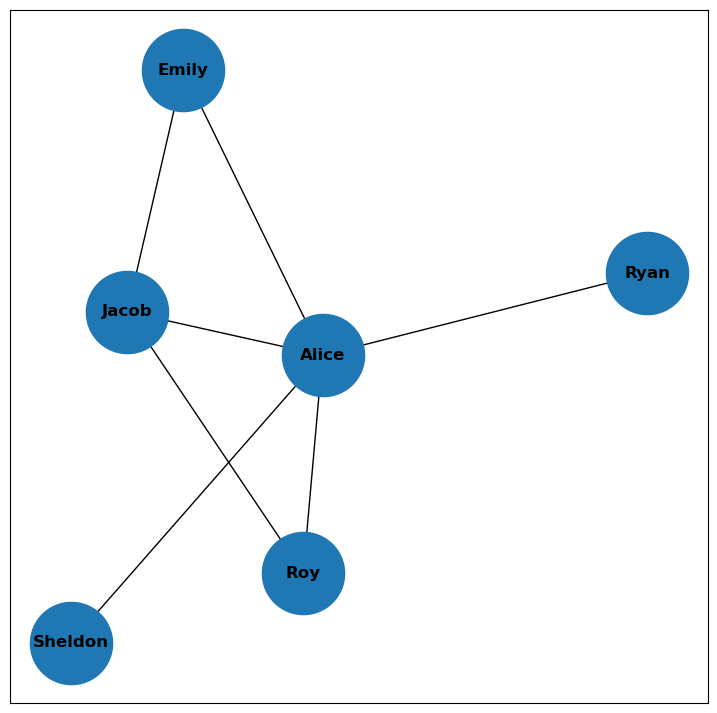

In [7]:
def plot_undirected_graph(edge_list):
    # edge list contains infor,ation about edges which have clear direction
    # hoowever we will diregard the the direction in this function
    # the first thing is to plot the figure
    plt.figure(figsize=(9,9))
    # we instantiate a networkx graoh object.
    # nx. graoh represents an undirected graph.
    gplot=nx.Graph()
    for row in edge_list.select("src", "dst").take(1000):
        gplot.add_edge(row["src"], row["dst"])
    nx.draw_networkx(gplot, with_labels=True, font_weight="bold", node_size=3500)
plot_undirected_graph(family_tree.edges)

inDegrees : number of incoming links to the vertex.</br>
outDegrees: number of outgoing edges from a node.

In [8]:
tree_degree = family_tree.degrees
tree_degree.show()

+-------+------+
|     id|degree|
+-------+------+
|Sheldon|     1|
|  Alice|     5|
|  Jacob|     3|
|  Emily|     2|
|   Ryan|     1|
|    Roy|     2|
+-------+------+



In [9]:
degree_edges = edges.filter(("src = 'Alice' or dst = 'Alice'"))
degree_edges.show()

+-------+-----+--------+
|    src|  dst|relation|
+-------+-----+--------+
|Sheldon|Alice|  Sister|
|  Alice|Jacob| Husband|
|   Ryan|Alice|  Friend|
|  Alice|Emily|Daughter|
|  Alice|  Roy|     Son|
+-------+-----+--------+



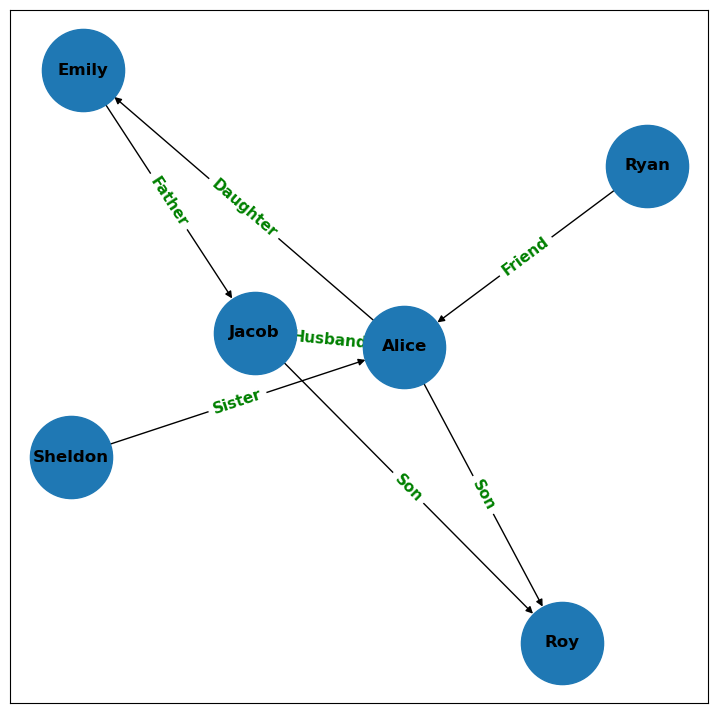

In [11]:
# the function will plot the source and destination nodes and connect them by meand of undirected line
def plot_directed_graph(edge_list):
    plt.figure(figsize=(9,9))
    gplot=nx.DiGraph()
    edge_labels = {}
    for row in edge_list.select("src", "dst", "relation").take(1000):
        gplot.add_edge(row["src"], row["dst"])
        edge_labels[(row["src"], row["dst"])] = row["relation"]
    pos = nx.spring_layout(gplot)
    nx.draw_networkx(gplot, pos, with_labels=True, font_weight="bold", node_size=3500)
    nx.draw_networkx_edge_labels(gplot, pos, edge_labels=edge_labels, font_color="green", font_size=11, font_weight="bold")
plot_directed_graph(family_tree.edges)

In [ ]:
plot_directed_graph(degree_edges)

In [8]:
from pyspark.sql.functions import col, lit, when
from functools import reduce
from graphframes import *

In [9]:
vertices = spark.createDataFrame([

  ("a", "Alice", 34),

  ("b", "Bob", 36),

  ("c", "Charlie", 30),

  ("d", "David", 29),

  ("e", "Esther", 32),

  ("f", "Fanny", 36),

  ("g", "Gabby", 60)], ["id", "name", "age"])

In [10]:
edges = spark.createDataFrame([

  ("a", "b", "friend"),

  ("b", "c", "follow"),

  ("c", "b", "follow"),

  ("f", "c", "follow"),

  ("e", "f", "follow"),

  ("e", "d", "friend"),

  ("d", "a", "friend"),

  ("a", "e", "friend")

], ["src", "dst", "relationship"])

In [11]:
g = GraphFrame(vertices, edges)

print(g)

GraphFrame(v:[id: string, name: string ... 1 more field], e:[src: string, dst: string ... 1 more field])


In [13]:
g.vertices.show()

+---+-------+---+
| id|   name|age|
+---+-------+---+
|  a|  Alice| 34|
|  b|    Bob| 36|
|  c|Charlie| 30|
|  d|  David| 29|
|  e| Esther| 32|
|  f|  Fanny| 36|
|  g|  Gabby| 60|
+---+-------+---+



In [14]:
g.edges.show()

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  a|  b|      friend|
|  b|  c|      follow|
|  c|  b|      follow|
|  f|  c|      follow|
|  e|  f|      follow|
|  e|  d|      friend|
|  d|  a|      friend|
|  a|  e|      friend|
+---+---+------------+



In [15]:
g.inDegrees.show()

+---+--------+
| id|inDegree|
+---+--------+
|  c|       2|
|  b|       2|
|  f|       1|
|  d|       1|
|  e|       1|
|  a|       1|
+---+--------+



In [16]:
g.outDegrees.show()

+---+---------+
| id|outDegree|
+---+---------+
|  b|        1|
|  a|        2|
|  f|        1|
|  c|        1|
|  e|        2|
|  d|        1|
+---+---------+



In [18]:
youngest = g.vertices.groupBy().min("age")
youngest.show()

+--------+
|min(age)|
+--------+
|      29|
+--------+



In [19]:
numFollows = g.edges.filter("relationship = 'follow'").count()
print("The number of follow edges is", numFollows)

The number of follow edges is 4
